In [61]:
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf

In [62]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0 * 2 -1, x_test / 255.0 * 2 -1

x_train.shape

(60000, 28, 28)

In [63]:
N, H, W = x_train.shape
D = H * W

x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

x_train.shape

(60000, 784)

In [64]:
latent_dim = 100

In [65]:
def build_generator(latent_dim):
    i = layers.Input(shape=(latent_dim,))
    x = layers.Dense(256, activation=layers.LeakyReLU(alpha=0.2))(i)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.Dense(512, activation=layers.LeakyReLU(alpha=0.2))(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.Dense(1024, activation=layers.LeakyReLU(alpha=0.2))(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.Dense(D, activation='tanh')(x)

    model = Model(i, x)
    return model

In [66]:
def build_discriminator(img_size):
    i = layers.Input(shape=(img_size,))
    x = layers.Dense(512, activation=layers.LeakyReLU(alpha=0.2))(i)
    x = layers.Dense(256, activation=layers.LeakyReLU(alpha=0.2))(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = Model(i, x)
    return model

In [67]:
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

In [68]:
generator = build_generator(latent_dim)
z = layers.Input(shape=(latent_dim,))
img = generator(z)

In [69]:
img

<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'model_7')>

In [70]:
discriminator.trainable = False

In [71]:
valid = discriminator(img)

In [72]:
valid

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'model_6')>

In [73]:
combined = Model(z, valid)

In [74]:
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [75]:
combined.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model_7 (Functional)         (None, 784)               1493520   
_________________________________________________________________
model_6 (Functional)         (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


In [76]:
batch_size = 32
epochs = 30000
sample_period = 1500

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

d_losses = []
g_losses = []

if not os.path.exists('gan_images'):
    os.makedirs('gan_images')


In [77]:
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)

    imgs = 0.5 * imgs + 0.5 # rescale images 0-1

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()

In [78]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [79]:
for epoch in range(epochs):
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]

    # generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)

    # train the discriminator
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    # train the generator
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined.train_on_batch(noise, ones)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

    if epoch % sample_period == 0:
        sample_images(epoch)

epoch: 1/30000, d_loss: 0.81, d_acc: 0.41, g_loss: 0.79
epoch: 101/30000, d_loss: 0.01, d_acc: 1.00, g_loss: 4.60
epoch: 201/30000, d_loss: 0.10, d_acc: 0.98, g_loss: 4.10
epoch: 301/30000, d_loss: 0.25, d_acc: 0.92, g_loss: 3.12
epoch: 401/30000, d_loss: 0.37, d_acc: 0.84, g_loss: 2.48
epoch: 501/30000, d_loss: 0.66, d_acc: 0.52, g_loss: 0.72
epoch: 601/30000, d_loss: 0.66, d_acc: 0.58, g_loss: 0.72
epoch: 701/30000, d_loss: 0.59, d_acc: 0.75, g_loss: 0.79
epoch: 801/30000, d_loss: 0.61, d_acc: 0.69, g_loss: 0.81
epoch: 901/30000, d_loss: 0.60, d_acc: 0.67, g_loss: 0.81
epoch: 1001/30000, d_loss: 0.66, d_acc: 0.56, g_loss: 0.74
epoch: 1101/30000, d_loss: 0.62, d_acc: 0.72, g_loss: 0.79
epoch: 1201/30000, d_loss: 0.65, d_acc: 0.62, g_loss: 0.88
epoch: 1301/30000, d_loss: 0.57, d_acc: 0.77, g_loss: 0.91
epoch: 1401/30000, d_loss: 0.64, d_acc: 0.59, g_loss: 0.90
epoch: 1501/30000, d_loss: 0.59, d_acc: 0.67, g_loss: 0.93
epoch: 1601/30000, d_loss: 0.53, d_acc: 0.81, g_loss: 0.97
epoch: 17

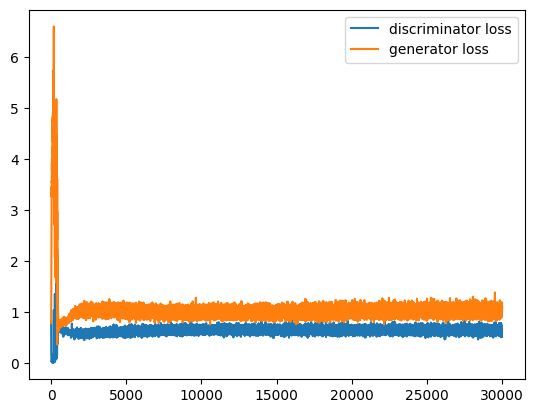

In [80]:
plt.plot(d_losses, label='discriminator loss')
plt.plot(g_losses, label='generator loss')
plt.legend()

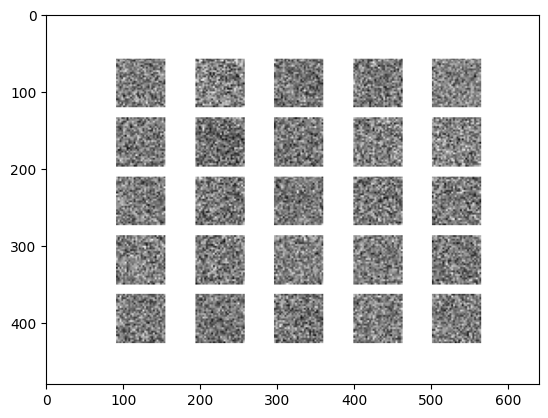

In [81]:
from skimage.io import imread
img = imread('gan_images/0.png')
plt.imshow(img)

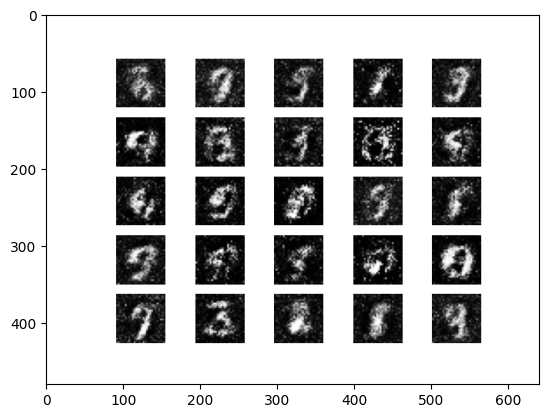

In [82]:
img = imread('gan_images/1500.png')
plt.imshow(img)

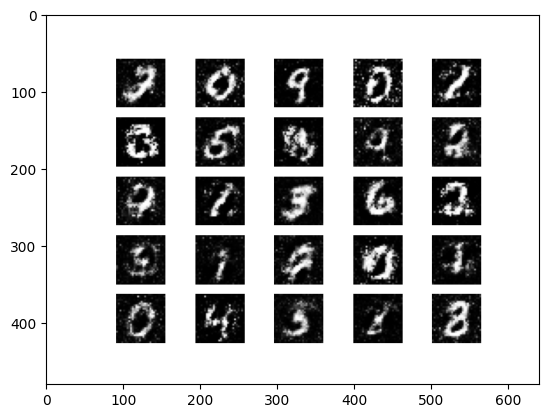

In [83]:
img = imread('gan_images/3000.png')
plt.imshow(img)

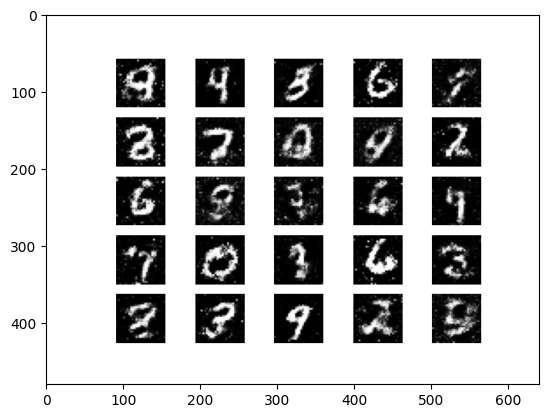

In [84]:
img = imread('gan_images/4500.png')
plt.imshow(img)

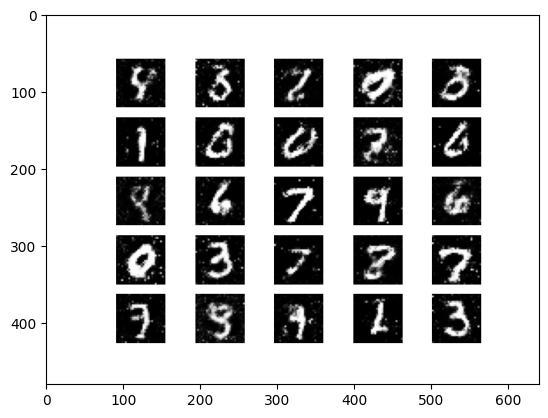

In [85]:
img = imread('gan_images/6000.png')
plt.imshow(img)

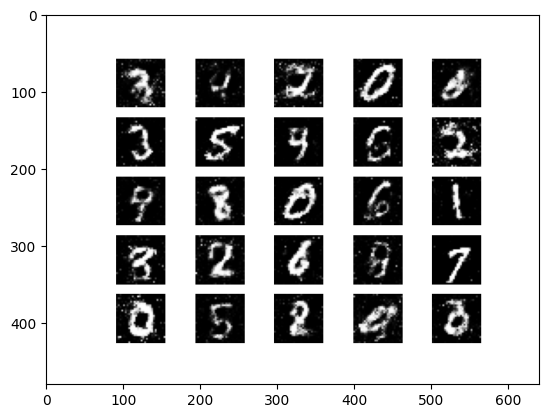

In [86]:
img = imread('gan_images/7500.png')
plt.imshow(img)

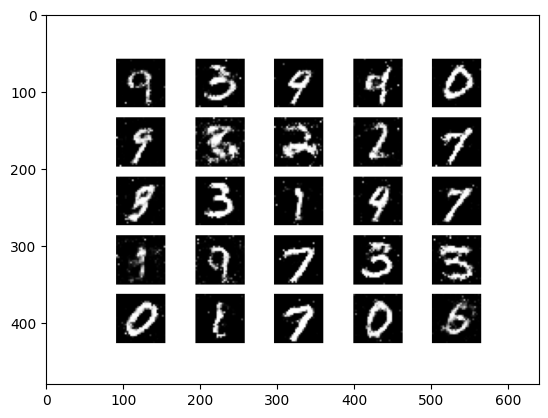

In [87]:
img = imread('gan_images/15000.png')
plt.imshow(img)

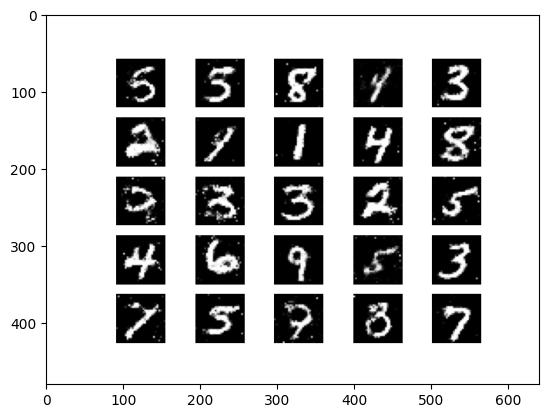

In [88]:
img = imread('gan_images/22500.png')
plt.imshow(img)

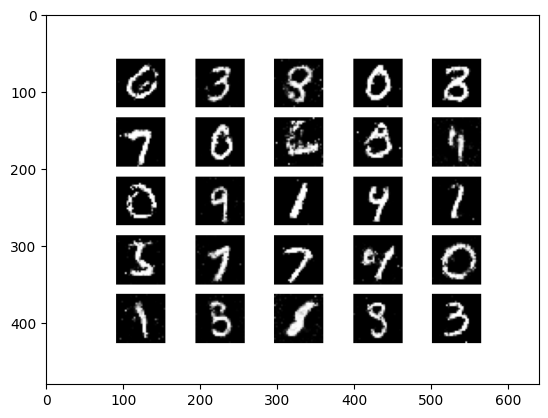

In [90]:
img = imread('gan_images/28500.png')
plt.imshow(img)